In [1]:
%matplotlib inline
import numpy as np
from scipy.interpolate import interp1d
import scipy.special as sps
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import collections as col
import scipy.constants as spc
import cmath as cmath
import warnings 

In [2]:
#Constant: Speed of light in m/s
c = spc.c

In [3]:
class Elements:
    elementCount = 0
    
    def __init__(self, chemSymb, wp, gamma, vf, A, RefracFile):
        self.chemSymb = chemSymb
        self.wp = wp #E15
        self.gamma = gamma
        self.vf = vf
        self.A = A
        self.RefracFile = RefracFile
        Elements.elementCount += 1

In [4]:
class Compounds:
    compoundsCount = 0
    
    def __init__(self,chemFormula,RefracFile):
        self.chemFormula = chemFormula
        self.RefracFile = RefracFile
        Compounds.compoundsCount += 1

In [5]:
Gold = Elements("Au", 2.0674, 0.0184, 1.40, 1.25, "Au_RefractiveIndexINFO.csv")
Silver = Elements("Ag" ,2.231274845 ,0.0228 ,1.39 ,1.25 ,"Ag_RefractiveIndexINFO.csv")
STO = Compounds("SrTiO3", "STO_RefractiveIndexINFO.csv")

In [6]:
#named Tuple, contains information about the particle geometry, and physical constants
def new_particle(name, CoreParticle,Shape, ClusterS ,R ,wp ,gamma ,vf ,A):
    particle = col.namedtuple(name,['CoreParticle', 'Shape', 'ClusterS', 'R', 'wp', 'gamma', 'vf', 'A'])
    particle.CoreParticle = CoreParticle
    particle.Shape = Shape
    particle.ClusterS = ClusterS
    particle.R = R #E-9 m
    particle.wp = wp #E15 Hz
    particle.gamma = gamma #E15 s
    particle.vf = vf #E6 m/s
    particle.A = A
    return particle

In [7]:
#Returns the entries of a file with one line header and all other lines entries, separated with (,) if multiple entries per line
def loadfile(FileName):
    data = np.loadtxt(FileName,skiprows=1,delimiter=",")
          
    data[:,0] = data[:,0]*1e3 #from um to nm (um default used on refractiveindex.info)
    return data

In [8]:
def extrapolate(data):
    
    LowerL = 120
    UpperL = 1240
    step = 1
    
    if data[0,0] < LowerL:
        LowerL = data[0,0]
    if data[data[:,0].size-1,0] > 1240:
        UpperL = data[data[:,0].size-1,0]
        
    x_val = np.arange(LowerL, UpperL, step, dtype = int) 
    nextp_f = np.polyfit(data[:,0],data[:,1],7)
    for k in range (1, 20,1):
        nextp_f = np.polyfit(data[:,0],data[:,1],k)
        nextp = np.poly1d(nextp_f)
        nex = nextp(x_val)
    
        if 3*data[:,0].size == data.size:
            kextp_f = np.polyfit(data[:,0],data[:,2],k)
            kextp = np.poly1d(kextp_f)
            kex = kextp(x_val)
        else:
            kex = np.zeros(nex.size)
        diff = 0
        for i in range (0,data[:,0].size-1,1):
            diff = 0 + (nex[int(data[i,0])-LowerL]-data[i,1])
        if abs(diff) < 1e-4:
            break
            
    extrapolate_data = np.transpose(np.stack((x_val,nex,kex),axis = 0))
    
    return extrapolate_data

In [9]:
#interpolates a data array [:,3] to have a value for every nm, by default 
def interpolate(data, lowerL = 200, higherL = 1240, step = 1):
        
    x_val = np.arange(lowerL, higherL, step, dtype = int)
    
    nval = interp1d(data[:,0], data[:,1], kind = 'cubic')
    ninp = nval(x_val)
    
    if 3*data[:,0].size == data.size:
        kval = interp1d(data[:,0], data[:,2], kind = 'cubic')
        kinp = kval(x_val)
    else:
        kinp = np.zeros(ninp.size)
    
    interp_data = np.transpose(np.stack((x_val,ninp,kinp),axis = 0))

    return interp_data

In [10]:
#calculates the real and imaginary part of a dielectric function based on n and k, where n is data[:,0] and k data[:,1]
def calc_diel_f(data0, data1):
    eps = np.zeros([data0.size,2])
    eps[:,0] = data0**2 - data1**2
    eps[:,1] = 2*data0*data1
    return eps

In [11]:
#Applies changes to the dielectric function of the particle based on the 
def ClusterSizeEffects(Eps, wl, R, wp, gamma, vf, A):
    
    freq = 1883.651565/wl
    freq2 = freq**2
    
    dgamma = gamma + A*vf/R
    dgamma2 = dgamma
    
    Eps[:,0] = Eps[:,0] + wp**2/(freq2+gamma**2)-wp**2/(freq2+dgamma2)
    Eps[:,1] = Eps[:,1] + wp**2/freq*(dgamma/(freq2+dgamma2)-gamma/(freq2+gamma**2))
    
    return Eps

In [12]:
def bessel_jn(l,x,der = False):
    jn = sps.spherical_jn(l, x, derivative = der)
    return jn

In [13]:
def bessel_yn(l,x,der = False):
    yn = sps.spherical_yn(l, x, derivative = der)
    return yn

In [14]:
def CoreSphereParticle(wl, epsP, epsM, R):
    X0 = 2*np.pi*R
    epsM = np.sqrt(epsM)
    
    epsP0 = np.sqrt(epsP[:,0]**2+epsP[:,1]**2)/2
    Y0 = np.sqrt(epsP[:,0]/2+epsP0)+1j*np.sqrt(-epsP[:,0]/2+epsP0)
    
    X = X0/wl*epsM[:,0]
    Y = X0/wl*Y0
    M = Y/X
    
    A = np.zeros(X.size)
    B = np.zeros(X.size)
    Qext = np.zeros(X.size)
    Qsca = np.zeros(X.size)
    
    
    L = 1
    while True:
        bjY  = bessel_jn(L,Y)
        bjX  = bessel_jn(L,X)
        byX  = bessel_yn(L,X)
        bjXp = bessel_jn(L,X,True)
         
        pmx  = Y*bjY
        pmxp = bjY + Y*bessel_jn(L,Y,True)
            
        px   = X*bjX
        pxp  = bjX + X*bjXp
        
        ex   = X*bjX +1j*X*byX
        exp  = bjX + X*bjXp + 1j*byX + 1j*X*bessel_yn(L,X,True)
                
        A = (M*pmx*pxp-pmxp*px)/(M*pmx*exp-pmxp*ex)
        B = (pmx*pxp-M*pmxp*px)/(pmx*exp-M*pmxp*ex)
        warnings.filterwarnings("ignore")
        if np.isnan(np.sum(A)) or np.isnan(np.sum(B)):
            print("NaN value at L = ", L)

            break
            
        AB = (A+B).real*(2*L+1)
        ABabs = (A*np.conj(A))+(B*np.conj(B))*(2*L+1)

        Qext = Qext + AB
        Qsca = Qsca + ABabs
        L += 1
        
    Qext = 2*Qext/X**2
    Qsca = 2*Qsca/X**2 
   
    return Qext, Qsca


NaN value at L =  98


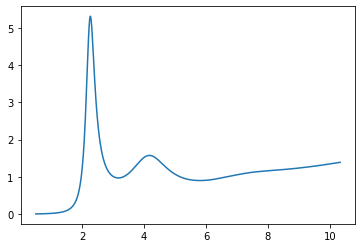

In [22]:
#Start of a new program. First, load the experimental data for the selected particle, geometry and matrix
IParticle_data = loadfile(Gold.RefracFile)
IMatrix_data = loadfile(STO.RefracFile)


#Extrapolate matrix data if necessary
if IMatrix_data[0,0] > 120 or IMatrix_data[IMatrix_data[:,0].size-1,0] < 1240:
    Matrix_data = extrapolate(IMatrix_data)
else:
    Matrix_data = IMatrix_data
    
#Extrapolate particle data if necessary
if IParticle_data[0,0] > 120 or IParticle_data[IParticle_data[:,0].size-1,0] < 1240:
    Particle_data = extrapolate(IParticle_data)
else:
    Particle_data = IParticle_data

#the same interpolation limits are applied to all materials involved (no extrapolation at the moment TODO: Extrapolation)
if Particle_data[0,0] < Matrix_data[0,0]:
    lowerL = Matrix_data[0,0]
else:
    lowerL = Particle_data[0,0]

if Particle_data[Particle_data[:,0].size-1, 0] > Matrix_data[Matrix_data[:,0].size-1, 0]:
    higherL = Matrix_data[Matrix_data[:,0].size-1, 0]
else:
    higherL = Particle_data[Particle_data[:,0].size-1, 0]
    
PD_int = interpolate(Particle_data,lowerL,higherL)
MD_int = interpolate(Matrix_data,lowerL,higherL)

#Particle = new_particle('AgParticle', True, 'Sphere', True, 10, Silver.wp, Silver.gamma, Silver.vf, Silver.A)
Particle = new_particle('AuParticle', True, 'Sphere', True, 10, Gold.wp, Gold.gamma, Gold.vf, Gold.A)
#Wavelength 
WL = PD_int[:,0]

#calculate the dielectric functions of the materials involved
TP_Eps = calc_diel_f(PD_int[:,1],PD_int[:,2])
M_Eps = calc_diel_f(MD_int[:,1],MD_int[:,2])

#obtain the changed dielectric function due to cluster size effects (particles only) or ignore them
if Particle.ClusterS:
    P_Eps = ClusterSizeEffects(TP_Eps, WL, Particle.R, Particle.wp, Particle.gamma, Particle.vf, Particle.A)
else:
    P_Eps = TP_Eps
    
#Calculate the Qext and Qsca if the particle is a core particle and spherical
if Particle.Shape == "Sphere" and Particle.CoreParticle:
    Qext, Qsca = CoreSphereParticle(WL, P_Eps, M_Eps, Particle.R)
#TODO: implement what happenes if particle is no a sphere and coreparticle
else:
    print("Please implement this")

plt.plot(1239.8/WL,Qext)